In [5]:
from __future__ import print_function, absolute_import, division
import math
import pandas as pd
from cmath import phase
import numpy as np
import warnings
from numpy import linalg as LA
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
import matplotlib.pyplot as plt
import tqdm
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

def spotfi_algorithm_1_package_one(csi_matrix):
    R = abs(csi_matrix)
    phase_matrix = np.vstack((np.unwrap(np.angle(csi_matrix[0,:])),np.unwrap(np.angle(csi_matrix[1,:]))))
    fit_X = np.concatenate((np.linspace(1,576,576),np.linspace(1,576,576)))
    fit_Y = np.concatenate((np.unwrap(np.angle(csi_matrix[0,:])),np.unwrap(np.angle(csi_matrix[1,:]))))
    tau_offset = np.polyfit(fit_X,fit_Y,1)[0]
    C = np.zeros((2,576),dtype=np.complex_)
    for m in range(phase_matrix.shape[0]):
        for n in range(phase_matrix.shape[1]):
            C[m,n] = np.exp(complex(0,phase_matrix[m,n] - (n)*tau_offset))
    # csi_matrix_clean = np.multiply(R,C)
    return C, tau_offset

def spotfi_algorithm_1(csi_matrix,C):
    R = abs(csi_matrix)
    csi_matrix_clean = np.multiply(R,C)
    return csi_matrix_clean


def smooth_csi(csi):
    smoothed_csi = np.zeros((30, 32), dtype=np.complex_)
    # Antenna 1 (values go in the uplter left quadrant)
    m = 0
    for ii in range(0, 15):
        n = 0
        for j in range(ii, ii+16):
            smoothed_csi[m, n] = csi[0, j]
            n = n + 1
        m = m + 1

    # Antenna 2

    # # Bottom left of smoothed csi matrix
    for ii in range(0, 15):
        n = 0
        for j in range(ii, ii+16):
            smoothed_csi[m, n] = csi[1, j] # 2 + sqrt(-1) * j;
            n = n + 1
        m = m + 1

    # Top right of smoothed csi matrix
    m = 0;
    for ii in range(0, 15):
        n = 16
        for j in range(ii, ii+16):
            smoothed_csi[m, n] = csi[1, j]  #2 + sqrt(-1) * j;
            n = n + 1
        m = m + 1

    # # Antenna 3 (values go in the lower right quadrant)
    # for ii in range(0, 15):
    #     n = 16
    #     for j in range(ii, ii+16):
    #         smoothed_csi[m, n] = csi[2, j]   #3 + sqrt(-1) * j;
    #         n = n + 1
    #     m = m + 1

    return smoothed_csi

def compute_steering_vector(theta, tau, freq, sub_freq_delta, antenna_distance):
    steering_vector = np.zeros(30,dtype=np.complex_)
    k = 0
    base_element = 1
    for ii in np.linspace(0,1,2):
        for jj in np.linspace(0,14,15):
            steering_vector[k] = base_element * pow(omega_tof_phase(tau, sub_freq_delta),(jj-1))
            k = k+1
        base_element = base_element *  phi_aoa_phase(theta, freq, antenna_distance)
    return steering_vector

def omega_tof_phase(tau, sub_freq_delta):
    time_phase = np.exp(-1j * 2 * math.pi * sub_freq_delta * tau)
    return time_phase
def phi_aoa_phase(theta, frequency, d):
    c = 3.0 * pow(10,8)
    # Convert to radians
    theta = theta / 180 * math.pi
    angle_phase = np.exp(-1j * 2 * math.pi * d * math.sin(theta) * (frequency / c))
    return angle_phase

def detect_peaks(image):
    neighborhood = generate_binary_structure(2,2)
    local_max = maximum_filter(image, footprint=neighborhood)==image
    background = (image==0)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)
    detected_peaks = local_max ^ eroded_background
    return detected_peaks

def aoa_tof_music(x, antenna_distance, frequency, sub_freq_delta, theta_range, tau_range):
    R = np.dot(x,x.conj().T)
    w, v = LA.eig(R)
    w = np.real(w)
    w = w/max(w)

    idx = (-w).argsort()[::-1]
    w = w[idx]
    v = v[:,idx]

    start_index = len(w)-2
    end_index = start_index - 10
    decrease_ratios = np.zeros(start_index - end_index + 1)

    k=0
    for ii in range(28, 17, -1):
        temp_decrease_ratio = w[ii + 1] / w[ii]
        decrease_ratios[k] = temp_decrease_ratio
        k = k + 1

    max_decrease_ratio_index = np.argmax(decrease_ratios)
    index_in_eigenvalues = len(w) - max_decrease_ratio_index
    num_computed_paths = len(w) - index_in_eigenvalues + 1

    # Estimate noise subspace
    column_indices = range(0, (len(w) - num_computed_paths))
    eigenvectors = v[:, list(column_indices)]

    # Peak search
    # theta_range = np.linspace(-90,90,91)
    # tau_range = np.linspace(0,3000 * pow(10,-9),61)
    Pmusic = np.zeros((len(theta_range), len(tau_range)))

    for ii in range(0, len(theta_range)):
        for jj in range(0, len(tau_range)):
            steering_vector = compute_steering_vector(theta_range[ii], tau_range[jj],frequency, sub_freq_delta, antenna_distance)
            plt = np.dot(np.dot(steering_vector.conj().T,eigenvectors),np.dot(eigenvectors.conj().T,steering_vector))
            Pmusic[ii,jj] = 10*math.log(np.abs(1/plt),10)
    detected_peaks = detect_peaks(Pmusic)
    maximum_idx_array = np.zeros(2)
    for i in range(detected_peaks.shape[0]):  #i: idx of theta
        for j in range(detected_peaks.shape[1]): #j: idx of tau
            if detected_peaks[i,j]==True:
                maximum_idx_array = np.vstack((maximum_idx_array,np.array([i,j])))
    maximum_idx_array=maximum_idx_array[1:,]
    return maximum_idx_array

def csi_plot(theta1, theta2, d):
    rad1 = theta1*math.pi/180
    rad2 = theta2*math.pi/180

    if theta1 == 0:
        x = 1
        k2 = math.tan(0.5*math.pi+rad2)
        y = -k2*d
    elif theta2 == 0:
        x = 1 + d
        k1 = math.tan(0.5*math.pi+rad1)
        y = k1*d
    else:
        k1 = math.tan(0.5*math.pi+rad1)
        k2 = math.tan(0.5*math.pi+rad2)
        x = d*k2/(k2-k1)+1
        y = d*k1*k2/(k2-k1)

    X = [1,1+d]
    Y = [0,0]
    plt.scatter(X,Y,color = 'deepskyblue')
    plt.scatter(x,y,color = 'salmon')
    plt.axis(ymin=0, ymax=1.2*y)
    plt.text(x,y+1,'({0},{1})'.format(x,y))
    return x,y

def csi_plot(theta_left, theta_mid, theta_right):
    # theta_left = result_aoas[0]
    # theta_mid = result_aoas[1]
    # theta_right = result_aoas[2]

    rad_left = theta_left * math.pi / 180
    rad_mid = theta_mid * math.pi / 180
    rad_right = theta_right * math.pi / 180

    k_left = math.tan(rad_left)
    k_mid = math.tan(rad_mid)
    k_right = math.tan(rad_right)

    x = np.zeros(3, dtype=float)
    y = np.zeros(3, dtype=float)

    x[0] = -2.23 * k_right / (k_right - k_mid)
    y[0] = 2.33 * k_right * k_mid / (k_mid - k_right)
    x[1] = 2.23 * k_left / (k_left - k_mid)
    y[1] = -2.33 * k_left * k_mid / (k_mid - k_left)

    x[2] = 2.33 * (k_left + k_right) / (k_left - k_right)
    y[2] = (x[2] - 2.33) * k_left

    print(x)
    print(y)

    X = [-2.33, 0, 2.33]
    Y = [0, 0, 0]
    Tar_x = [0]
    Tar_y = [2.54]
    plt.scatter(X, Y, color='blue', label="Signal Receiver")
    plt.scatter(x, y, color='salmon', label="Candidate location")
    plt.scatter(Tar_x, Tar_y, color='green', label="True location")
    plt.legend(loc=0)
    plt.axis(ymin=0, ymax=4)
    plt.show()

def dbinv(x):
    ret = 10**(x/10)
    return ret

def db(x):
    try: # if input is a series
        ret = 10.*np.log10(list(x))
        return ret
    except: # if input is a number
        ret = 10.*np.log10(x)
        return ret

def rssi(file_data):
    rssi_mag = dbinv(file_data["rssi_a"])+dbinv(file_data["rssi_b"])+dbinv(file_data["rssi_c"])
    rssi_ = db(rssi_mag) - 44 - file_data['agc']
    return rssi_

def rssi2dist(rssi_,A,n):
    dist = 10**((A-rssi_)/(10*n))
    return dist

def dist2rssi(d,A,n):
    ret = A - 10*n*np.log10(d)
    return ret

def ecldDist(coor1, coor2):
    dist = math.sqrt((coor1[0]-coor2[0])**2+(coor1[1]-coor2[1])**2)
    return dist

def coord2aoa(coorAP, coorTar):
    tang = (coorTar[1]-coorAP[1])/(coorTar[0]-coorAP[0])
    theta = math.atan(tang)/math.pi*180-90
    return theta

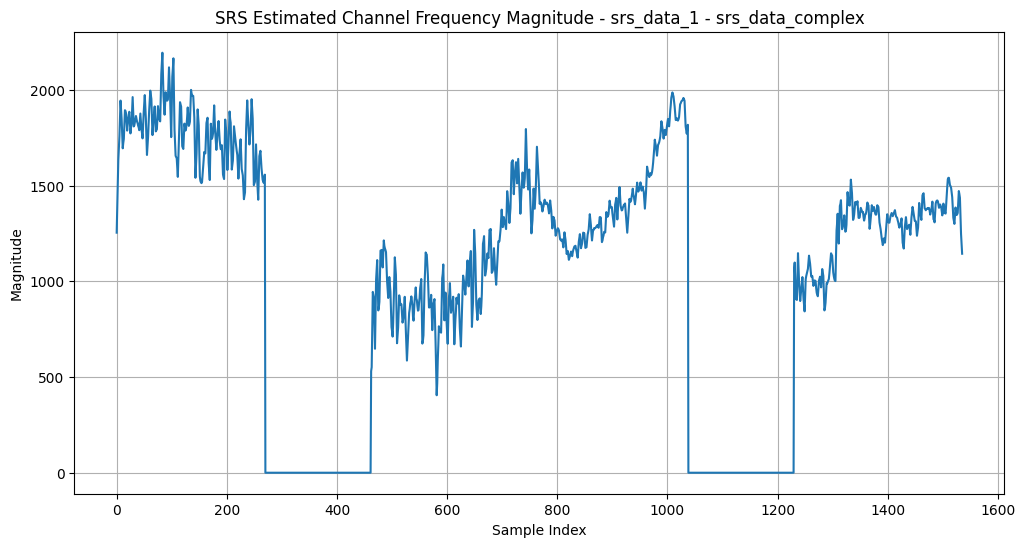

3
(2, 576)


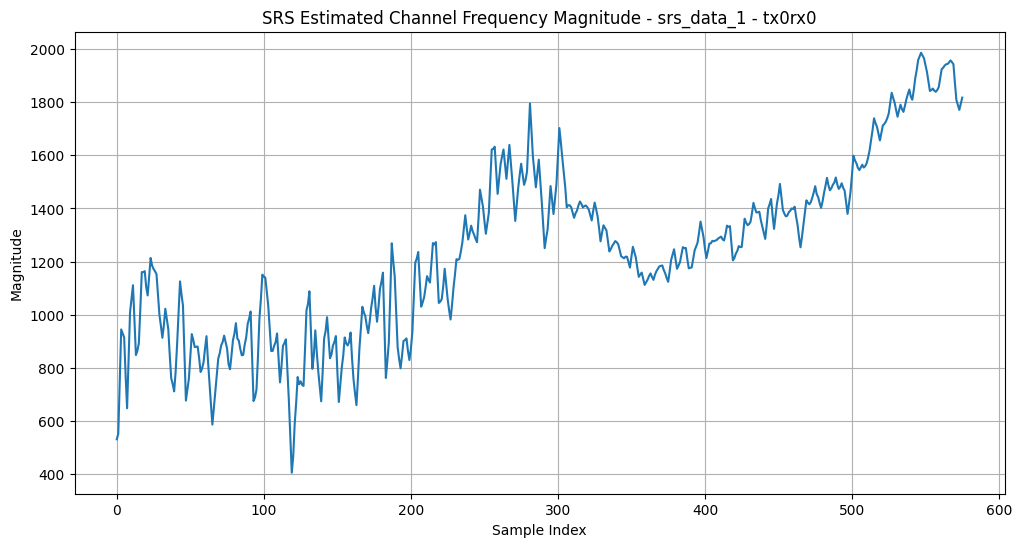

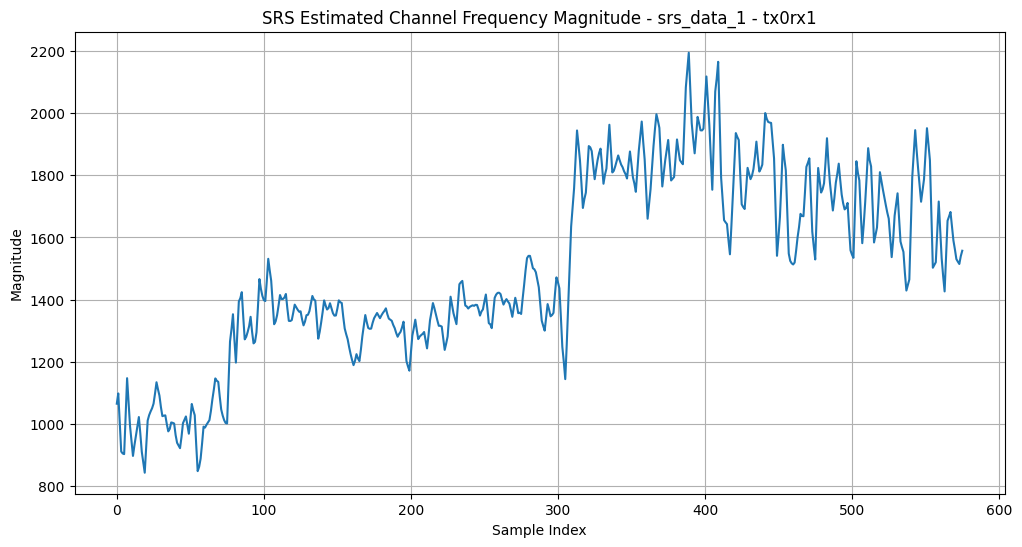

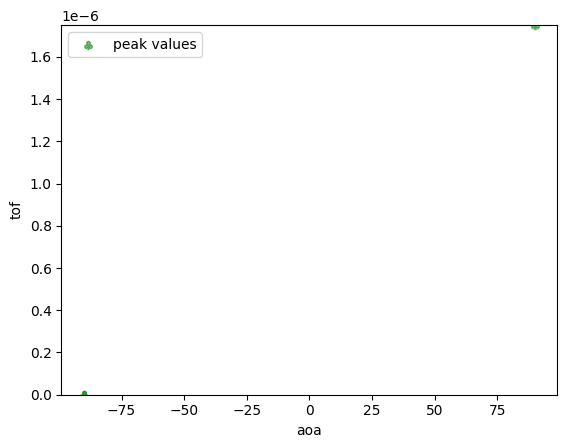

  cluster cnt aoa_mean  tof_mean aoa_variance tof_variance likelihood
0       1   3    -30.0  0.000001      10800.0          0.0     -43.17


/tmp/ipykernel_2632610/2795674251.py:191: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_likelihood['likelihood'].fillna(0, inplace=True)
/tmp/ipykernel_2632610/2795674251.py:193: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object 

In [6]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def int32_to_complex16(int32_val):
    # Extract real and imaginary parts from int32
    real = np.int16(int32_val & 0xFFFF)
    imag = np.int16(int32_val >> 16)
    
    # Convert to complex number
    return complex(real, imag)

# Read the .mat file
mat_contents = scipy.io.loadmat('srs_data.mat')

# Get all variables starting with 'srs_data_'
srs_data_vars = [key for key in mat_contents.keys() if key.startswith('srs_data_')]

# Sort the variables to ensure they're in order
srs_data_vars.sort(key=lambda x: int(x.split('_')[-1]))

i = 0

all_maximum_idx_array = np.zeros(2)

# Process each dataset
for var_name in srs_data_vars:
    srs_data_int32 = mat_contents[var_name].flatten()

    # Convert int32 data to complex16
    srs_data_complex = np.array([int32_to_complex16(val) for val in srs_data_int32])

    # print(f"\nProcessing {var_name}")
    # print(f"Number of complex elements: {len(srs_data_complex)}")
    # print(f"Data type: {srs_data_complex.dtype}")
    # print(f"Min magnitude: {np.min(np.abs(srs_data_complex))}")
    # print(f"Max magnitude: {np.max(np.abs(srs_data_complex))}")
    # print(f"Mean magnitude: {np.mean(np.abs(srs_data_complex))}")

    # split the array srs_data_complex into subarrays where the value is 0
    def split_remove_zeros(array):
        mask = array != 0
        indices = np.where(mask[1:] != mask[:-1])[0] + 1
        if mask[0]:
            indices = np.r_[0, indices]
        if mask[-1]:
            indices = np.r_[indices, len(array)]
        indices = indices.reshape(-1, 2)
        return [array[start:end] for start, end in indices]

    # plot the magnitude of the complex data
    plt.figure(figsize=(12, 6))
    plt.plot(np.abs(srs_data_complex))
    plt.title(f'SRS Estimated Channel Frequency Magnitude - {var_name} - srs_data_complex')
    plt.xlabel('Sample Index')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.show()

    result = split_remove_zeros(srs_data_complex)

    print(len(result))

    # tx0rx0 = result[1]
    # tx1rx0 = result[2]
    # tx0rx1 = result[3]
    # tx1rx1 = np.concatenate([result[4], result[0]])

    tx0rx0 = result[1]
    tx0rx1 = np.concatenate([result[2], result[0]])


    
    antenna_distance = 0.03
    frequency = 2.5 * pow(10, 9)
    #sub_freq_delta = 3125 #312.5K
    sub_freq_delta = 300 # 30k
    theta_range = np.linspace(-90,90,91)
    tau_range = np.linspace(0,3000 * pow(10,-9),61)


    result_aoas = np.array([0.0])

    csi_matrix = np.stack((tx0rx0,  tx0rx1), axis=0)

    print(csi_matrix.shape)
    C, tau_offset = spotfi_algorithm_1_package_one(csi_matrix)

    csi_matrix_clean = spotfi_algorithm_1(csi_matrix, C)

    # return the smoothed_csi matrix
    smoothed_csi = smooth_csi(csi_matrix_clean)
    maximum_idx_array = aoa_tof_music(smoothed_csi, antenna_distance, frequency,
                                                    sub_freq_delta, theta_range, tau_range)
    all_maximum_idx_array = np.vstack((all_maximum_idx_array, maximum_idx_array))

    
    
    # plot the magnitude of the complex data
    # plt.figure(figsize=(12, 6))
    # plt.plot(np.abs(tx0rx0))
    # plt.title(f'SRS Estimated Channel Frequency Magnitude - {var_name} - tx0rx0')
    # plt.xlabel('Sample Index')
    # plt.ylabel('Magnitude')
    # plt.grid(True)
    # plt.show()

    # plt.figure(figsize=(12, 6))
    # plt.plot(np.abs(tx1rx0))
    # plt.title(f'SRS Estimated Channel Frequency Magnitude - {var_name} - tx1rx0')
    # plt.xlabel('Sample Index')
    # plt.ylabel('Magnitude')
    # plt.grid(True)
    # plt.show()

    # plt.figure(figsize=(12, 6))
    # plt.plot(np.abs(tx0rx1))
    # plt.title(f'SRS Estimated Channel Frequency Magnitude - {var_name} - tx0rx1')
    # plt.xlabel('Sample Index')
    # plt.ylabel('Magnitude')
    # plt.grid(True)
    # plt.show()

    # plt.figure(figsize=(12, 6))
    # plt.plot(np.abs(tx1rx1))
    # plt.title(f'SRS Estimated Channel Frequency Magnitude - {var_name} - tx1rx1')
    # plt.xlabel('Sample Index')
    # plt.ylabel('Magnitude')
    # plt.grid(True)
    # plt.show()




    i+=1

    if i == 100:
        break


candicate_aoa_tof = np.zeros(2)
for i in range(all_maximum_idx_array.shape[0]):
    c_candicate = np.array((theta_range[int(all_maximum_idx_array[i, 0])], tau_range[int(all_maximum_idx_array[i, 1])]))
    candicate_aoa_tof = np.vstack((candicate_aoa_tof, c_candicate))
candicate_aoa_tof = candicate_aoa_tof[1:, ]

raw_package_results = pd.DataFrame(candicate_aoa_tof, columns=['aoa', 'tof'])

plt.scatter(raw_package_results['aoa'], raw_package_results['tof'], c="g", alpha=0.5, marker=r'$\clubsuit$',
               label="peak values")
plt.ylim(ymax=raw_package_results['tof'].max(), ymin=0)
# plt.ylim()
plt.xlabel("aoa")
plt.ylabel("tof")
plt.legend(loc=2)
plt.show()

import scipy.cluster.hierarchy as sch
disMat = sch.distance.pdist(candicate_aoa_tof, 'euclidean')
Z = sch.linkage(disMat, method='ward')
# P=sch.dendrogram(Z)

raw_package_results['cluster'] = sch.fcluster(Z, t=1.115, criterion='inconsistent', depth=2)
clusters = sorted(raw_package_results['cluster'].unique())

data_likelihood = pd.DataFrame(columns=['cluster', 'cnt', 'aoa_mean', 'tof_mean', 'aoa_variance', 'tof_variance'])
for i in clusters:
    data_likelihood.loc[i - 1, 'cluster'] = i
    data_likelihood.loc[i - 1, 'cnt'] = sum(raw_package_results['cluster'] == i)
    data_likelihood.loc[i - 1, 'aoa_mean'] = (
    raw_package_results['aoa'][raw_package_results['cluster'] == i]).mean()
    data_likelihood.loc[i - 1, 'tof_mean'] = (
    raw_package_results['tof'][raw_package_results['cluster'] == i]).mean()
    data_likelihood.loc[i - 1, 'aoa_variance'] = (
    raw_package_results['aoa'][raw_package_results['cluster'] == i]).var()
    data_likelihood.loc[i - 1, 'tof_variance'] = (
    raw_package_results['tof'][raw_package_results['cluster'] == i]).var()

weight_num_cluster_points = 0.01
weight_aoa_variance = -0.004
weight_tof_variance = -0.0016
weight_tof_mean = -0.0000
constant_offset = -1

data_likelihood['likelihood'] = (weight_num_cluster_points * data_likelihood['cnt'] \
                                    + weight_aoa_variance * data_likelihood['aoa_variance'] \
                                    + weight_tof_variance * data_likelihood['tof_variance'] \
                                    + weight_tof_mean * data_likelihood['tof_mean'])

data_likelihood['likelihood'].fillna(0, inplace=True)
# cheating
data_likelihood['likelihood'][data_likelihood['aoa_mean'] == -90] = 0
data_likelihood['likelihood'][data_likelihood['aoa_mean'] == 90] = 0

print (data_likelihood)